# Линейная регрессия
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][MS][ML][HW03] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [17]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy

In [18]:
def read_data(path="boston.csv"):
    dataframe = np.genfromtxt(path, delimiter=",", skip_header=15)
    np.random.seed(42)
    np.random.shuffle(dataframe)
    X = dataframe[:, :-1]
    y = dataframe[:, -1]
    return X, y

In [19]:
def generate_synthetic(size:int, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

### Задание 1 (1 балл)
Для начала нужно понять, какую метрику для ошибки будем использовать. В нашем случае нам подойдет стандартная метрика MSE. Также чтобы оценить качество модели нам понадобится метрика $R^2$. Реализуйте обе эти метрики.

In [20]:
def mse(y_true:np.ndarray, y_predicted:np.ndarray):
    mse = sum((y_predicted-y_true)**2)/y_true.shape[0]
    return mse

def r2(y_true:np.ndarray, y_predicted:np.ndarray):
    m = np.mean(y_true)
    u = sum((y_predicted-y_true)**2)
    v = sum((m-y_true)**2)
    R = 1 - u/v
    return R

### Задание 2 (3 балла)
Теперь реализуем линейную регрессию при помощи явного решения задачи минимизации. 

#### Методы
`fit(X, y)` - решает задачу минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$. 

`predict(X)` - строит предсказание `y` для объектов из `X`.

In [21]:
class StandardScaler:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit(self, X): #считаем среднее и стандартное отклонение
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)
        return self

    def transform(self, X): #пересчитываем
        X = (X - self.mean) / self.std
        return X
    
    def fit_transform(self, X):  #вместе
        X = self.fit(X).transform(X)
        return X
    
    def restore(self, X):
        X = self.std * X + self.mean
        return X

In [22]:
class NormalLR:
    def __init__(self, isnorm = True):
        self.w = None
        self.xscaler = StandardScaler() #чтобы нормировать Х
        self.yscaler = StandardScaler() #чтобы нормировать у
        self.isnorm = isnorm
        
    def xscl(self, X):
        X_scaled = self.xscaler.fit_transform(X)
        return X_scaled
    
    def yscl(self, y):
        y_scaled = self.yscaler.fit_transform(y)
        return y_scaled
        
    def fit(self, X:np.ndarray, y:np.ndarray):
        if self.isnorm:
            X = self.xscl(X)
            y = self.yscl(y)
            
        z = np.ones(X.shape[0]).reshape(-1, 1)
        X_new = np.hstack((z, X)) #добавили единицы, чтобы b записать в вектор w
        self.w = np.linalg.inv(X_new.T @ X_new) @ X_new.T @ y
       
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        if self.isnorm: 
            X = self.xscl(X)

        z = np.ones(X.shape[0]).reshape(-1, 1)
        X_new = np.hstack((z, X))
        y_pred = X_new @ self.w
        
        if self.isnorm:
            y_pred = self.yscaler.restore(y_pred)
            
        return y_pred

In [23]:
X, y = generate_synthetic(1024)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [24]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.04892054398277534, R2: 0.9888157953645074


### Задание 3 (2 балла)
Теперь реализуем линейную регрессию с использованием градиентного спуска с larning rate `alpha` в течении `iterations` итераций. В задании необходимо использовать регуляризацию Лассо с коэффициентом `l`.

#### Методы
`fit(X, y)` - приближает решение задачи минимизации $\arg\min_{w, b}\sum ((w\cdot x + b) - y)^2$ при помощи градиентного спуска. 


`predict(X)` - строит предсказание `y` для объектов из `X`.

In [165]:
class GradientLR:
    def __init__(self, alpha:float, iterations=10000, l=0., isnorm = True):
        self.alpha = alpha
        self.iterations = iterations
        self.l = l
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        self.isnorm = isnorm
        self.w = None
    
    def xscl(self, X):
        X_scaled = self.xscaler.fit_transform(X)
        return X_scaled
    
    def yscl(self, y):
        y_scaled = self.yscaler.fit_transform(y)
        return y_scaled
     
        
    def fit(self, X:np.ndarray, y:np.ndarray):
        if self.isnorm:
            X = self.xscl(X)
            y = self.yscl(y)
        
        z = np.ones(X.shape[0]).reshape(-1, 1)
        X_new = np.hstack((z, X)) #добавили единицы, чтобы b записать в вектор w
        
        prev = np.zeros(X_new.shape[1])
        estimate = np.zeros(X_new.shape[1])
        
        for _ in range(self.iterations):
            prev = estimate
            deriv = (1 / X.shape[0]) * X_new.T @ (X_new @ prev - y) + self.l * np.sign(prev) #сосчитали производную
            estimate = estimate - self.alpha * deriv
            if np.linalg.norm(estimate-prev) < 0.000001: #если близки
                break
        self.w = estimate
    
    def predict(self, X:np.ndarray) -> np.ndarray:
        if self.isnorm: 
            X = self.xscl(X)

        z = np.ones(X.shape[0]).reshape(-1, 1)
        X_new = np.hstack((z, X))
        y_pred = X_new @ self.w
        
        if self.isnorm:
            y_pred = self.yscaler.restore(y_pred)
            
        return y_pred

In [249]:
def build_plot(X_train, y_train, X_test, y_test, left=0.005, right=0.0012):
    #xs = np.arange(0.0, 0.006, 0.00002)
    xs = np.linspace(left, right, 100)
    errors = []
    for x in xs:
        regr = GradientLR(0.1, iterations=10000, l=x)
        regr.fit(X_train, y_train)
        errors.append(mse(y_test, regr.predict(X_test)))
    plt.figure(figsize=(9, 4))
    plt.xlim(xs[0], xs[-1])
    plt.grid()
    plt.plot(xs, errors)
    plt.show()

In [250]:
X, y = generate_synthetic(1024)
X, X_val, y, y_val = train_test_split(X, y, train_size=0.9, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

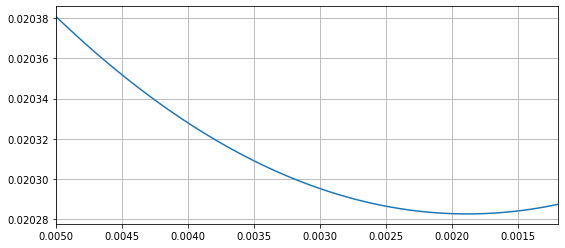

In [251]:
build_plot(X_train, y_train, X_val, y_val)

In [202]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f"MSE: {mse(y_test, y_pred)}, R2: {r2(y_test, y_pred)}")

MSE: 0.018757025342243543, R2: 0.9981084995040337


### Задание 4 (2 балла)
Протесируйте оба метода на данных `boston.csv`, для градиентного спуска постройте график зависимости ошибки от коэффициента регуляризации. 

In [217]:
X, y = read_data()
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, shuffle=False)

In [218]:
regr = NormalLR()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 23907612.01182961, R2: 0.6642284195038757


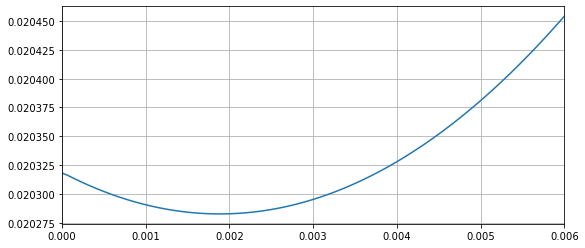

In [252]:
build_plot(X_train, y_train, X_val, y_val, left=0.0, right=0.006)

In [221]:
regr = GradientLR(0.1, iterations=10000)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_val)
print(f"MSE: {mse(y_val, y_pred)}, R2: {r2(y_val, y_pred)}")

MSE: 23907363.23346695, R2: 0.6642319134832819


### Задание 5 (2 балла)
Проинтерпритируйте полученные результаты. Опишите влияние каждого признака на результат предсказания.

Рассмотрим, что у нас получилось на линейной регрессии с LASSO регурялизацией. Описание признаков, взятое из файла:

  1. crim     per capita crime rate by town	
  2. zn       proportion of residential land zoned for lots over 25,000 sq.ft.	
  3. indus    proportion of non-retail business acres per town	
  4. chas     Charles River dummy variable (= 1 if tract bounds river	 0 otherwise)
  5. nox      nitric oxides concentration (parts per 10 million)	
  6. rm       average number of rooms per dwelling	
  7. age      proportion of owner-occupied units built prior to 1940	
  8. dis      weighted distances to five Boston employment centres	
  9. rad      index of accessibility to radial highways	


 10. tax      full-value property-tax rate per 10,000	
 11. ptratio  pupil-teacher ratio by town	
 12. b        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town	
 13. lstat    % lower status of the population	

In [281]:
num = np.arange(len(regr.w[1:]))+1
pr = sorted(list(zip(regr.w[1:], num)))
for item in pr:
    print(f'Weight: {item[0]:.10f}, feature number: {item[1]}')

Weight: -0.4271481481, feature number: 13
Weight: -0.3507917243, feature number: 8
Weight: -0.2617815451, feature number: 10
Weight: -0.2141228233, feature number: 5
Weight: -0.2098617128, feature number: 11
Weight: -0.1010168127, feature number: 1
Weight: -0.0146815145, feature number: 3
Weight: 0.0315025564, feature number: 7
Weight: 0.0629941538, feature number: 4
Weight: 0.0851286234, feature number: 12
Weight: 0.1352358505, feature number: 2
Weight: 0.2781097032, feature number: 6
Weight: 0.3050971636, feature number: 9


 Самыми значимыми положительно влияющими признаками оказались `rad`(близость к крупным дорогам) и `rm`(среднее количество количество комнат в жилище), а самыми значимыми негативно влияющими оказались `lstat`(статус населения), `dis`(расстояния до 5 бостонских центров занятости), `tax`(налог на недвидимость), `nox`(содержание окиси азота в воздухе). Это вполне согласуется со здравым смыслом: чем больше комнат, тем дороже квартира, а доступность транспорта - один из важнейших аспетов при покупке жилья. Токсичные выбросы и большой процент населения без должного образования/рабочих же указывает на неблагоприятный район. На мой взгляд интересно, что переменная `b` (процент чернокожего населения) дает небольшой положительный вклад, и странно, что переменная `crim` дает только небольшой отрицательный - я бы ожидала, что это будет самым плохим фактором.